# 题目：单车共享数量预测

任务描述：       
请在Capital Bikeshare （美国Washington, D.C.的一个共享单车公司）提供的自行车数据上进行回归分析。训练数据为2011年的数据，要求预测2012年每天的单车共享数量。 

需要提交代码文件，并给出必要的结果解释。   
1) 训练数据和测试分割（ 请将 2012 年的数据 作为测试）；（ 20 分）    
2) 适当的特征工程 （及数据探索） ;（20 分）        
    提示：          
    a) 有些特征看起来是数据值，其实类别型如月份、季节      
    b) 数值型特征归一化         
    c) 可以丢弃一些不必要的特征           
3) 岭回归，并选择最佳的正则参数； （30分）          
    a) 参数调优           
    b) 结果可视化             
4) LassoLasso LassoLasso，并选择最佳的正则参数 ；（ 30分）           

## 1 导入必要的工具包

In [53]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O

from sklearn.metrics import r2_score  #评价回归预测模型的性能

import matplotlib.pyplot as plt
import seaborn as sns
#color = sns.color_palette()

# 图形出现在Notebook里而不是新窗口
%matplotlib inline

## 2 读取数据

In [54]:
# path to where the data lies
dpath = './data/'
data = pd.read_csv(dpath+"day.csv")
data.head()
#===============================
# 输入
# Instant记录号
# Dteday：日期
# Season：季节
# 1=春天 2=夏天 3=秋天 4=冬天
# yr：年份，(0: 2011, 1:2012)
# mnth：月份( 1 to 12)
# hr：小时 (0 to 23) （只在hour.csv有，作业忽略此字段）
# holiday：是否是节假日
# weekday：星期中的哪天，取值为0～6
# workingday：是否工作日
# 1=工作日 （非周末和节假日） 0=周末
# weathersit：天气
# 1：晴天，多云 2：雾天，阴天 3：小雪，小雨 4：大雨，大雪，大雾
# temp：气温摄氏度
# atemp：体感温度
# hum：湿度
# windspeed：风速
#===============================
# 输出
# casual：非注册用户个数
# registered：注册用户个数
# cnt：给定日期（天）时间（每小时）总租车人数，响应变量y  
#===============================
#理解题目的日期（天）是指day.csv，时间（每小时）是指hour.csv文件，并指定只选day.csv分析即可


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


temp：气温摄氏度
atemp：体感温度
hum：湿度
windspeed：风速              
这几个参数什么单位？考虑商业原因可能处理过了。

In [55]:
#开头全是2011年的数据，看一下后段是不是2012年的数据？其实在哪里没有关系，但是必须有
data.tail()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796
730,731,2012-12-31,1,1,12,0,1,1,2,0.215833,0.223487,0.577500,0.154846,439,2290,2729


## 数据基本信息

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
instant       731 non-null int64
dteday        731 non-null object
season        731 non-null int64
yr            731 non-null int64
mnth          731 non-null int64
holiday       731 non-null int64
weekday       731 non-null int64
workingday    731 non-null int64
weathersit    731 non-null int64
temp          731 non-null float64
atemp         731 non-null float64
hum           731 non-null float64
windspeed     731 non-null float64
casual        731 non-null int64
registered    731 non-null int64
cnt           731 non-null int64
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


# 3 特征预处理

In [57]:
#object(1)是什么鬼？# Dteday：日期，没用还不好处理，去掉吧
#DataFrame.drop(labels=None, axis=0（0:index,1:column）, index=None, columns=None, level=None, inplace=False, errors='raise')[source]¶
data = data.drop('dteday', axis = 1)

In [58]:
#为啥第一列是编号，省点计算机功耗，早点丢掉吧
data = data.drop('instant', axis = 1)

In [59]:
### 查看是否有空值
data.isnull().sum()

season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

## 探索数据

查看数据各特征的分布，以及特征之间是否存在相关关系等冗余。

我们可以借用可视化工具来直观感觉数据的分布。

在Python中，有很多数据可视化途径。
Matplotlib非常强大，也很复杂，不易于学习。 
Seaborn是在matplotlib的基础上进行了更高级的API封装，从而使得作图更加容易，在大多数情况下使用seaborn就能做出很具有吸引力的图，而使用matplotlib就能制作具有更多特色的图。

In [60]:
## 各属性的统计特性
data.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


此处得到各属性的样本数目、均值、标准差、最小值、1/4分位数（25%）、中位数（50%）、3/4分位数（75%）、最大值           
可初步了解各特征的分布                     
#看着好像没啥问题

### 单变量分布分析

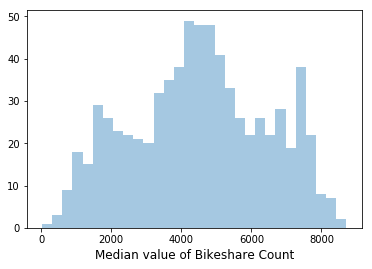

In [61]:
# 目标y的直方图
#新建画板
fig = plt.figure()
#设置：待观测数据是cnt的数值，箱子数目30，kde拟合（True时纵坐标是归一化值，False时纵坐标是个数）
sns.distplot(data.cnt.values, bins=30, kde=False)
#标签X轴：按天计的单车共享次数的中值
plt.xlabel('Median value of Bikeshare Count', fontsize=12)
#在画板上显示
plt.show()

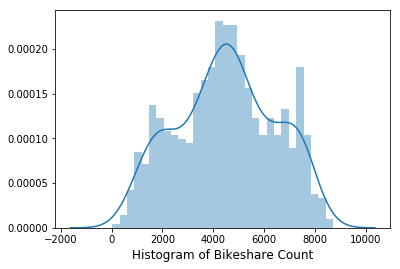

In [62]:
# 目标y的分布
#新建画板
fig = plt.figure()
#设置：待观测数据是cnt的数值，箱子数目30，kde拟合（True时纵坐标是归一化值，False时纵坐标是个数）
sns.distplot(data.cnt.values, bins=30, kde=True)#
#标签X轴：按天计的单车共享次数的中值
plt.xlabel('Histogram of Bikeshare Count', fontsize=12)
#在画板上显示
plt.show()

上图，不像正态分布

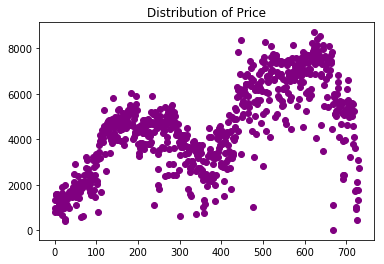

In [63]:
# 单个特征散点图
plt.scatter(range(data.shape[0]), data["cnt"].values,color='purple')
plt.title("Distribution of Price");

由散点图可以看出，        
1）数据呈马鞍状，其中峰值在200和550附近，极可能是夏天共享单车多；         
谷值在350附近和730左右，极可能是冬天单车共享人数少。       
在接近680的位置，貌似是离群点。        
2）为啥2012年的单车数量（右侧峰值）比2011年（左侧峰值）高了这么多？是否仅仅是自然因素      

In [64]:
#发现散点图上的一个孤立点
#找到改点的数值查看
cnt_min = np.min(data.cnt)
print(cnt_min)
# cnt_min_indice = np.where(cnt_min)
# #print "Indice of cnt minimum:", 
# cnt_min_indice.values

22


In [65]:
# 去掉改点：一个由于cnt散点是整数，且只有一个，而且10.29这一天也不是特殊节日，直接去掉
#data = data[data.cnt!=np.min(data.cnt)] #此语句有隐含错误：如果每次执行，每次会少一行，可能把有用数据去掉，舍弃不用
data = data[data.cnt!=22]#最小值22

In [66]:
#不分析的数也去掉吧，不然画相关图有十几个，太消耗时间，且影响分析结果
data = data.drop('casual', axis = 1)
data = data.drop('registered', axis = 1)

In [67]:
data.shape

(730, 12)

## 输入属性的直方图／分布     
时间属性就不看了 统计值是已知的，包括年、月、日、周末、工作日  
但是随机变量要看，包括天气、气温、体感温度、湿度、风速           
放这里，省的找：weathersit	holiday temp	atemp	hum	windspeed

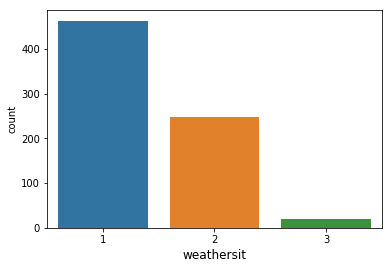

In [68]:
#weathersit：离散变量，用countplot
fig = plt.figure()
# sns.distplot(data.weathersit.values, bins=30, kde=False)
sns.countplot(data.weathersit.values)
plt.xlabel('weathersit', fontsize=12)
plt.show()

有图可见，藐小的Washington, D.C.几乎不下雨。

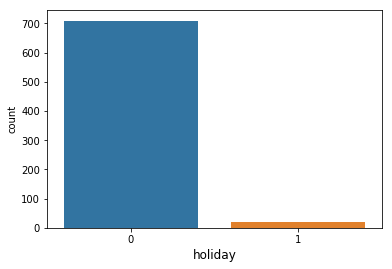

In [69]:
#holiday：离散变量，用countplot
fig = plt.figure()
# sns.distplot(data.weathersit.values, bins=30, kde=False)
sns.countplot(data.holiday.values)
plt.xlabel('holiday', fontsize=12)
plt.show()

假期不比大中华多

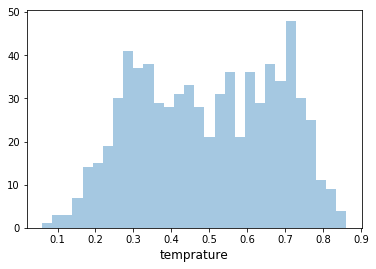

In [70]:
#temp：连续变量
fig = plt.figure()
sns.distplot(data.temp.values, bins=30, kde=False)
plt.xlabel('temprature', fontsize=12)
plt.show()

由图可见，温度也是双驼峰状，应该是夏季高温，冬天冷

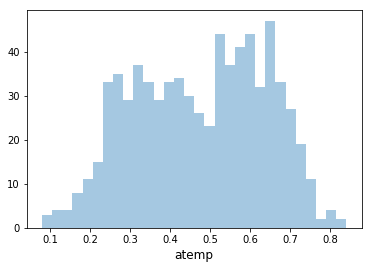

In [71]:
fig = plt.figure()
sns.distplot(data.atemp.values, bins=30, kde=False)
plt.xlabel('atemp', fontsize=12)
plt.show()

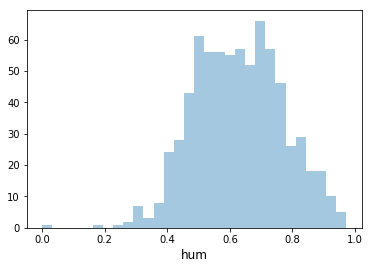

In [72]:
fig = plt.figure()
sns.distplot(data.hum.values, bins=30, kde=False)#True
plt.xlabel('hum', fontsize=12)
plt.show()

上图，  
1）看着是个正态分布，右偏      
2）左侧有一点离群点

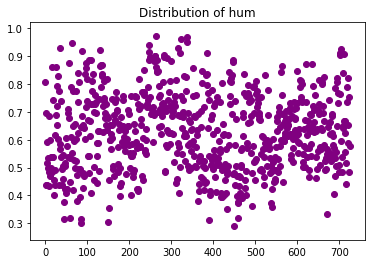

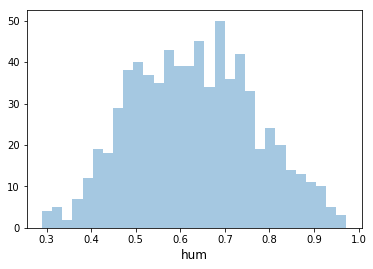

In [73]:
#去掉左侧异常点
ulimit_min = np.percentile(data.hum.values, 0.5)
data = data[data.hum > ulimit_min]
fig = plt.figure()
plt.scatter(range(data.shape[0]), data["hum"].values,color='purple')
plt.title("Distribution of hum");
fig = plt.figure()
sns.distplot(data.hum.values, bins=30, kde=False)#True
plt.xlabel('hum', fontsize=12)
plt.show()

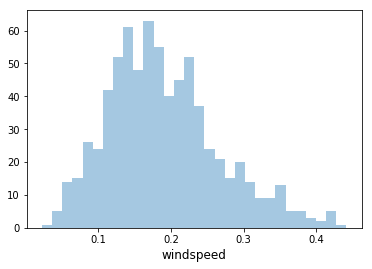

In [74]:
fig = plt.figure()
sns.distplot(data.windspeed.values, bins=30, kde=False)
plt.xlabel('windspeed', fontsize=12)
plt.show()

上图：      
1) 风速，正态左偏。     
2) 原始数据在右侧最大值0.5处有一个离群点，但是前面处理去掉湿度的离群点后，风速的离群点也不见了，考虑是在同一个样本。  

In [75]:
#去掉风速异常点
#湿度去掉离群点后，风速离群点不见了，此处不需要去了，注释掉
# ulimit_max = np.percentile(data.windspeed.values, 99.9)
# data = data[data.windspeed < ulimit_max]
# fig = plt.figure()
# plt.scatter(range(data.shape[0]), data["windspeed"].values,color='purple')
# plt.title("Distribution of Windspeed");
# fig = plt.figure()
# sns.distplot(data.windspeed.values, bins=30, kde=False)#True
# plt.xlabel('windspeed', fontsize=12)
# plt.show()

# 类型转换处理：
类型特征转换为数值特征      
类型特征包括：季节、月份、星期         
天气特征数值定义和降水量正相关，因此此处作为数值特征考虑。

In [76]:
# #引入类型转换器，尝试未果
# from sklearn.feature_extraction import DictVectorizer
# #sparse=False：不用稀疏矩阵表示
# dict_vec = DictVectorizer(sparse=False)

# # X_train = dict_vec.fit_transform(X_train.to_dict(orient='record'))
# data = dict_vec.fit_transform(data.to_dict(orient='record'))
# dict_vec.feature_names_ #查看转换之后的特征维度
# # data.head() # 转换后的训练集

# 使用pandas手动独热编码，过拟合相当严重，训练系数数值一度达到5位数，有待后续进一步探索
# feature=['season','mnth','weekday'] #,'weathersit'
# data = pd.get_dummies(data,prefix=tuple(feature),columns=feature)

In [77]:
#看一下独热one-hot是否起作用了
# data.head()

## 两两特征之间的相关性
终于可以看一下春夏秋冬和温度以及体感温度的关系了


In [78]:
#get the names of all the columns
#备用：后续提示时用到
cols=data.columns 

# Calculates pearson co-efficient for all combinations，通常认为相关系数大于0.5的为强相关
data_corr = data.corr().abs()

In [79]:
data_corr.shape

(12, 12)

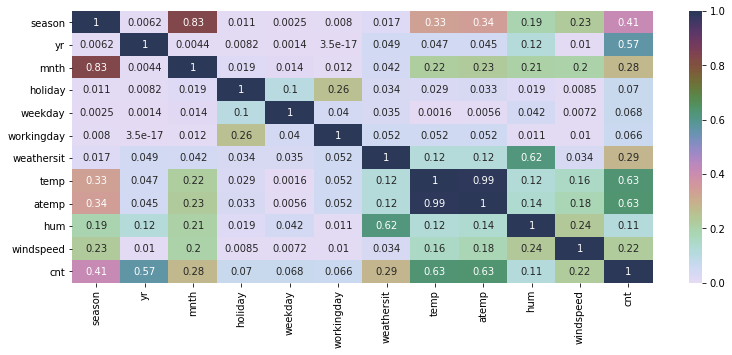

In [80]:
plt.subplots(figsize=(13, 5))#画小点，一屏显示完
# seaborn.heatmap(data, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g', 
#                 annotkws=None, linewidths=0, linecolor='white', cbar=True, cbarkws=None, cbar_ax=None, 
#                 square=False, ax=None, xticklabels=True, yticklabels=True, mask=None, **kwargs)
# cubehelix map颜色
cmap = sns.cubehelix_palette(start = 1.5, rot = 3, gamma=0.8, as_cmap = True)
sns.heatmap(data_corr,annot=True,cmap=cmap)

# Mask unimportant features
sns.heatmap(data_corr,mask=data_corr <= 1, cbar=False)#True,cmap='YlGnBu'

#存个图片
plt.savefig('Bikeshare_corr.png' )
plt.show()

上图，温度和体感温度强相关，天气和湿度也强相关       
下面拍个序看

In [81]:
#Set the threshold to select only highly correlated attributes
threshold = 0.5
# List of pairs along with correlation above threshold
corr_list = []
#size = data.shape[1]
size = data_corr.shape[0]

#Search for the highly correlated pairs
for i in range(0, size): #for 'size' features
    for j in range(i+1,size): #avoid repetition
        if (data_corr.iloc[i,j] >= threshold and data_corr.iloc[i,j] < 1) or (data_corr.iloc[i,j] < 0 and data_corr.iloc[i,j] <= -threshold):
            corr_list.append([data_corr.iloc[i,j],i,j]) #store correlation and columns index

#Sort to show higher ones first            
s_corr_list = sorted(corr_list,key=lambda x: -abs(x[0]))

#Print correlations and column names
for v,i,j in s_corr_list:
    print ("%s and %s = %.2f" % (cols[i],cols[j],v))

temp and atemp = 0.99
season and mnth = 0.83
atemp and cnt = 0.63
temp and cnt = 0.63
weathersit and hum = 0.62
yr and cnt = 0.57


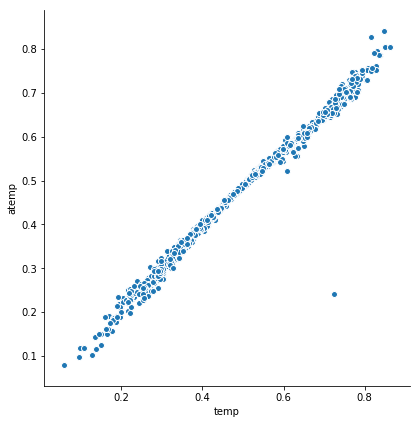

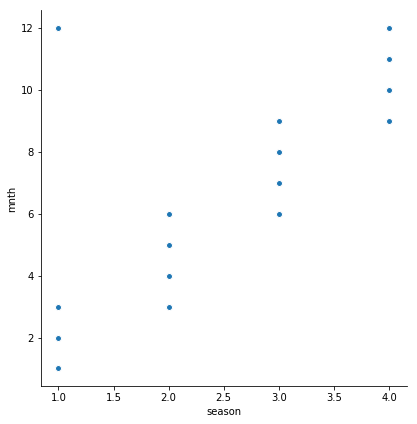

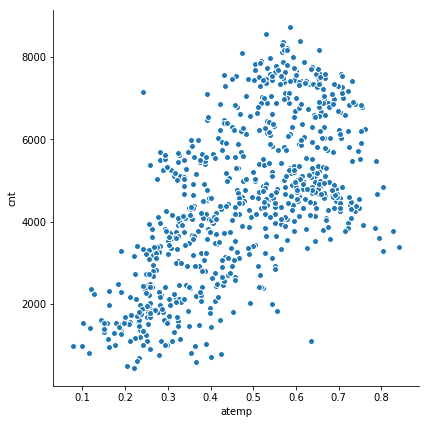

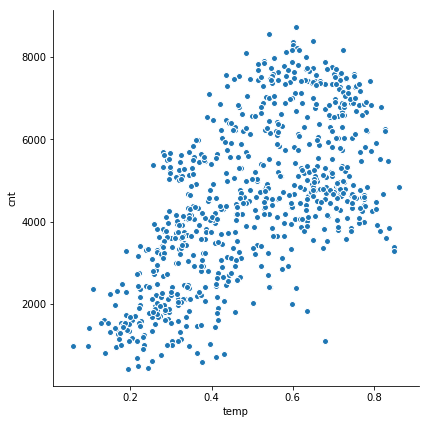

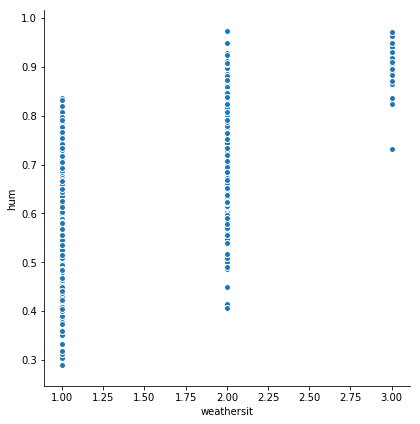

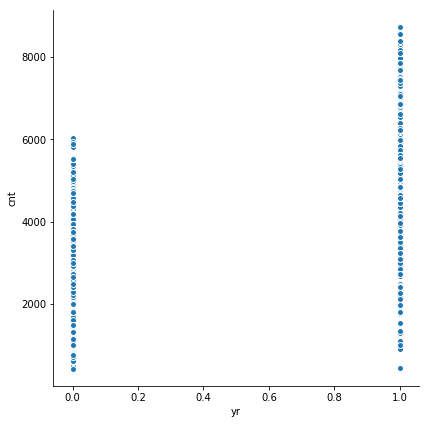

In [82]:
# Scatter plot of only the highly correlated pairs
for v,i,j in s_corr_list:
    sns.pairplot(data, size=6, x_vars=cols[i],y_vars=cols[j] )
    plt.show()

## 降维：把强相关数据去掉       
温度和体感温度



In [83]:
#温度和体感温度，保留温度，去掉体感温度
data = data.drop('atemp', axis = 1)

In [84]:
#季节和月份，保留月份，去掉季节，测试效果不好，注释掉
#data = data.drop('season', axis = 1)
# data = data.drop('mnth', axis = 1)
#去掉,测试效果不好，注释掉
#data = data.drop('hum', axis = 1)
# data = data.drop('holiday', axis = 1)

In [85]:
data.shape

(726, 11)

# 4 数据准备（数据探索）

下面按照题目要求，训练数据取2011年数据，测试数据取2012年数据。

In [86]:
#分拆训练集和测试集
data_train = data[data.yr == 0]
data_test  = data[data.yr == 1]

In [87]:
#分完数据，年没有用了，去掉试一下
data_train = data_train.drop('yr', axis = 1)
data_test = data_test.drop('yr', axis = 1)

In [88]:
#看一下训练集结构对不对
data_train.describe()

,season,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
count,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000
mean,2.506887,6.548209,0.027548,2.997245,0.685950,1.418733,0.487175,0.646693,0.190338,3418.305785
std,1.108397,3.448879,0.163900,2.004827,0.464777,0.566936,0.189993,0.143246,0.075193,1371.587749
min,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.302174,0.022392,431.000000
25%,2.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.324584,0.540625,0.135577,2133.500000
50%,3.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.484167,0.647917,0.186571,3744.000000
75%,3.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.658334,0.742563,0.234052,4588.000000
max,4.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.849167,0.972500,0.422275,6043.000000


In [89]:
#看一下测试集结构对不对
data_test.describe()

,season,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
count,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000
mean,2.493113,6.517906,0.030303,2.991736,0.685950,1.366391,0.504452,0.613341,0.188754,5613.024793
std,1.113370,3.460365,0.171656,1.999292,0.464777,0.510308,0.176773,0.131508,0.077849,1770.550198
min,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.107500,0.290000,0.046650,441.000000
25%,1.500000,3.500000,0.000000,1.000000,0.000000,1.000000,0.347083,0.508750,0.133709,4371.000000
50%,3.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.514167,0.612500,0.174129,5936.000000
75%,3.000000,9.500000,0.000000,5.000000,1.000000,2.000000,0.654583,0.710625,0.229279,7021.500000
max,4.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.925000,0.441563,8714.000000


2012年的单车共享数量的均值大约是2011年的近2倍，什么原因 

In [90]:
#分拆特征X和输出y
y_train = data_train['cnt'].values
X_train = data_train.drop('cnt', axis = 1)
y_test = data_test['cnt'].values
X_test = data_test.drop('cnt', axis = 1)

#用于后续显示权重系数对应的特征
columns = X_train.columns

常识笔记：数据预处理／特征工程

特征工程是实际任务中特别重要的环节。

scikit learn中提供的数据预处理功能：           
http://scikit-learn.org/stable/modules/preprocessing.html      
http://scikit-learn.org/stable/modules/classes.html#module-          
sklearn.feature_extraction

标准化：    
各特征差异较大，需要进行数据标准化预处理        
标准化的目的在于避免原始特征值差异过大，导致训练得到的参数权重不归一，无法比较各特征的重要性

In [91]:
# 数据标准化
from sklearn.preprocessing import StandardScaler

# 分别初始化对特征和目标值的标准化器
ss_X = StandardScaler()
ss_y = StandardScaler()

# 分别对训练和测试数据的特征以及目标值进行标准化处理
# 训练集和测试集需要用同样的标准化器
X_train = ss_X.fit_transform(X_train)
X_test = ss_X.transform(X_test)

#对y做标准化不是必须
#对y标准化的好处是不同问题的w差异不太大，同时正则参数的范围也有限
y_train = ss_y.fit_transform(y_train.reshape(-1, 1))
y_test = ss_y.transform(y_test.reshape(-1, 1))

归一化：      
对非常小的标准偏差的特征更鲁棒  
在稀疏数据中保留零条目    

In [92]:
#数据归一化
#==============================
# 其中本次任务归一化效果不如标准化，因此未选择归一化处理。
# 效果不好，注释掉了。
#==============================
# from sklearn.preprocessing import MinMaxScaler

# # 分别初始化对特征和目标值的归一化器
# mms_X = MinMaxScaler()
# mms_y = MinMaxScaler()

# # 分别对训练和测试数据的特征以及目标值进行处理
# # 训练集和测试集需要用同样的标准化器
# X_train = mms_X.fit_transform(X_train)
# X_test = mms_X.transform(X_test)

# y_train = mms_y.fit_transform(y_train.reshape(-1, 1))
# y_test = mms_y.transform(y_test.reshape(-1, 1))


# 5、确定模型类型

### 5.1 尝试缺省参数的线性回归

5.1.1 训练和预测

In [93]:
# 线性回归
#class sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)
#=====================================
#参数要牢记：
# fit_intercept：是否存在截距，默认存在
# normalize：标准化开关，默认关闭
# copy_X ：数据是否备份
# n_jobs ：使用的线程数目
#=====================================
from sklearn.linear_model import LinearRegression

# 使用默认配置初始化
lr = LinearRegression()

# 训练模型参数
lr.fit(X_train, y_train)

# 预测
y_test_pred_lr = lr.predict(X_test)
y_train_pred_lr = lr.predict(X_train)


# 看看各特征的权重系数，系数的绝对值大小可视为该特征的重要性
fs = pd.DataFrame({"columns":list(columns), "coef":list((lr.coef_.T))})
fs.sort_values(by=['coef'],ascending=False)

,coef,columns
6,[0.6449039075072264],temp
0,[0.29019802053253385],season
3,[0.03566557031310492],weekday
1,[0.009914171129053961],mnth
4,[0.004316539173812384],workingday
2,[-0.038639896354532],holiday
7,[-0.09179701946161267],hum
8,[-0.12223224558991738],windspeed
5,[-0.1962887490407437],weathersit


上表：          
影响大的特征：温度、季节、周末、风速、天气          
年值：特征值好小,e-17，由于所有样本年数值都是0，是个常数，没有信息量，去掉再运行；           
温度：系数很高，天气好了才骑车；              
周末：系数高，有闲余时间；  
风速等：风小季暖天气好，利于骑车；      
holiday:为啥是负的？考虑是样本太少了，检查数据发现，一年中节假日太少。

5.1.2 模型评价

In [94]:
# 使用r2_score评价模型在测试集和训练集上的性能，并输出评估结果
#测试集
print 'The r2 score of LinearRegression on test is', r2_score(y_test, y_test_pred_lr)
#训练集
print 'The r2 score of LinearRegression on train is', r2_score(y_train, y_train_pred_lr)

The r2 score of LinearRegression on test is -0.7105072093270834
The r2 score of LinearRegression on train is 0.7579151290305353


预测是负数不对，经过特征处理、数据处理等尝试未果，考虑可能和数据中的特征的全面性有关

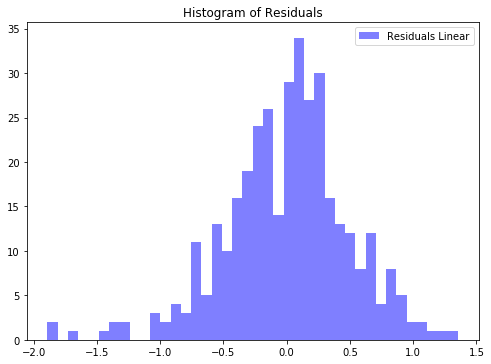

In [95]:
#在训练集上观察预测残差的分布，看是否符合模型假设：噪声为0均值的高斯噪声
f, ax = plt.subplots(figsize=(7, 5)) 
f.tight_layout() 
ax.hist(y_train - y_train_pred_lr,bins=40, label='Residuals Linear', color='b', alpha=.5); 
ax.set_title("Histogram of Residuals") 
ax.legend(loc='best');

残差分布和高斯分布比较匹配，但还是右skew，左侧有极小点，可能是               
1）和风速和湿度的离群点无关：去掉湿度和风速的离群点，该小值仍然存在；但是可能和风速分布有关，由于与cnt是负相关，因此可能造成cnt左侧预测，有噪声（预测残差＜-1.5）。               
2）y在数据中能看见，数值400多的数据存在不少，但是似乎都是正常值，不是离散点

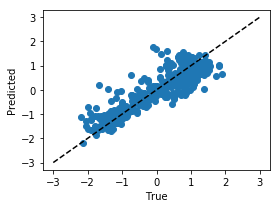

In [96]:
#观察预测值与真值的散点图
plt.figure(figsize=(4, 3))
plt.scatter(y_train, y_train_pred_lr)
plt.plot([-3, 3], [-3, 3], '--k')   #数据已经标准化，3倍标准差即可
plt.axis('tight')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.tight_layout()

小结：     
1）还算一致，除了个别点偏；       
2）前面的数据处理，对拟合效果和是否过拟合有重要影响。

## 5.2 线性回归之随机梯度下降法

5.2.1 训练和预测

In [97]:
# 线性模型，随机梯度下降优化模型参数
# 随机梯度下降一般在大数据集上应用，其实本项目不适合用
from sklearn.linear_model import SGDRegressor

# 使用默认配置初始化线
sgdr = SGDRegressor(max_iter=1000)

# 训练：参数估计
sgdr.fit(X_train, y_train)

# 预测
sgdr_y_predict = sgdr.predict(X_test)

# 看看各特征的权重系数，系数的绝对值大小可视为该特征的重要性
fs = pd.DataFrame({"columns":list(columns), "coef":list((sgdr.coef_.T))})
fs.sort_values(by=['coef'],ascending=False)
# sgdr.coef_

,coef,columns
6,0.645087,temp
0,0.290325,season
3,0.035986,weekday
1,0.009938,mnth
4,0.004791,workingday
2,-0.038320,holiday
7,-0.092441,hum
8,-0.122000,windspeed
5,-0.196778,weathersit


In [98]:
# 使用SGDRegressor模型自带的评估模块(评价准则为r2_score)，并输出评估结果
print 'The value of default measurement of SGDRegressor on test is', sgdr.score(X_test, y_test)
print 'The value of default measurement of SGDRegressor on train is', sgdr.score(X_train, y_train)

The value of default measurement of SGDRegressor on test is -0.7091125647380652
The value of default measurement of SGDRegressor on train is 0.7579134915630298


# 5.3 正则化的线性回归（L2正则 --> 岭回归）

In [99]:
#岭回归／L2正则
#class sklearn.linear_model.RidgeCV(alphas=(0.1, 1.0, 10.0), fit_intercept=True, 
#                                  normalize=False, scoring=None, cv=None, gcv_mode=None, 
#                                  store_cv_values=False)
from sklearn.linear_model import  RidgeCV

#设置超参数（正则参数）范围
# alphas = [ 0.01, 0.1, 1, 10,100]
#参数调优，多找几个点
n_alphas = 20
alphas = np.logspace(-2,2,n_alphas)

#生成一个RidgeCV实例
ridge = RidgeCV(alphas=alphas, store_cv_values=True)  

#模型训练
ridge.fit(X_train, y_train)    

#预测
y_test_pred_ridge = ridge.predict(X_test)
y_train_pred_ridge = ridge.predict(X_train)

# 看看各特征的权重系数，系数的绝对值大小可视为该特征的重要性
# fs = pd.DataFrame({"columns":list(columns), "coef":list((ridge.coef_.T))})
# fs.sort_values(by=['coef'],ascending=False)


In [100]:
# 评估，使用r2_score评价模型在测试集和训练集上的性能
print 'The r2 score of RidgeCV on test is', r2_score(y_test, y_test_pred_ridge)
print 'The r2 score of RidgeCV on train is', r2_score(y_train, y_train_pred_ridge)

The r2 score of RidgeCV on test is -0.7167199653742111
The r2 score of RidgeCV on train is 0.7577841922639693


# 可视化

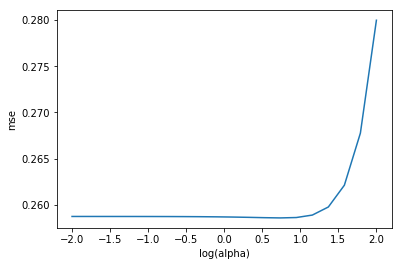

('alpha is:', 5.455594781168514)


In [101]:
mse_mean = np.mean(ridge.cv_values_, axis = 0)
plt.plot(np.log10(alphas), mse_mean.reshape(len(alphas),1)) 

#这是为了标出最佳参数的位置，不是必须
#plt.plot(np.log10(ridge.alpha_)*np.ones(3), [0.28, 0.29, 0.30])

plt.xlabel('log(alpha)')
plt.ylabel('mse')
plt.show()

print ('alpha is:', ridge.alpha_)

上图，alpha的最佳值。最小值分界线不是很明显，基本能看出来。

In [102]:
# 看看各特征的权重系数，系数的绝对值大小可视为该特征的重要性
fs = pd.DataFrame({"columns":list(columns), "coef_lr":list((lr.coef_.T)), "coef_ridge":list((ridge.coef_.T))})
fs.sort_values(by=['coef_lr'],ascending=False)

,coef_lr,coef_ridge,columns
6,[0.6449039075072264],[0.6358317708538302],temp
0,[0.29019802053253385],[0.2810389748075029],season
3,[0.03566557031310492],[0.03459014329464005],weekday
1,[0.009914171129053961],[0.019631518108113075],mnth
4,[0.004316539173812384],[0.0046541107521047564],workingday
2,[-0.038639896354532],[-0.03847952747392469],holiday
7,[-0.09179701946161267],[-0.08965630261917445],hum
8,[-0.12223224558991738],[-0.12095302350234455],windspeed
5,[-0.1962887490407437],[-0.19540814602315792],weathersit


# 5.4 正则化的线性回归（L1正则 --> Lasso）

In [103]:
#### Lasso／L1正则
# class sklearn.linear_model.LassoCV(eps=0.001, n_alphas=100, alphas=None, fit_intercept=True, 
#                                    normalize=False, precompute=’auto’, max_iter=1000, 
#                                    tol=0.0001, copy_X=True, cv=None, verbose=False, n_jobs=1,
#                                    positive=False, random_state=None, selection=’cyclic’)
from sklearn.linear_model import LassoCV

#设置超参数搜索范围
#alphas = [ 0.01, 0.1, 1, 10,100]
#参数调优，中心点附件范围，多找几个点
n_alphas = 20
alphas = np.logspace(-4,2,n_alphas)
#生成一个LassoCV实例
lasso = LassoCV(alphas=alphas) 
# lasso = LassoCV()  

#训练（内含CV）
lasso.fit(X_train, y_train)  

#测试
y_test_pred_lasso = lasso.predict(X_test)
y_train_pred_lasso = lasso.predict(X_train)


# 评估，使用r2_score评价模型在测试集和训练集上的性能
print 'The r2 score of LassoCV on test is', r2_score(y_test, y_test_pred_lasso)
print 'The r2 score of LassoCV on train is', r2_score(y_train, y_train_pred_lasso)

#比较一下，特征共线性对LASSO的影响
#不去掉体感温度时，
# The r2 score of LassoCV on test is -0.9044733766262709
# The r2 score of LassoCV on train is 0.6951915495643619
#去掉体感温度时，
# The r2 score of LassoCV on test is -0.9049050775194258
# The r2 score of LassoCV on train is 0.6933859959317998

The r2 score of LassoCV on test is -0.8872088643266056
The r2 score of LassoCV on train is 0.6918788146482748


In [104]:
# 看看各特征的权重系数，系数的绝对值大小可视为该特征的重要性
fs = pd.DataFrame({"columns":list(columns), "coef":list((lasso.coef_.T))})
fs.sort_values(by=['coef'],ascending=False)

,coef,columns
6,0.545450,temp
0,0.194522,season
1,0.000000,mnth
2,-0.000000,holiday
3,0.000000,weekday
4,0.000000,workingday
7,-0.000000,hum
8,-0.003430,windspeed
5,-0.127073,weathersit


上表小结：        
1）5个特征的系数为0(或近似0)，确实体现了LASSO的降维作用。

# 可视化

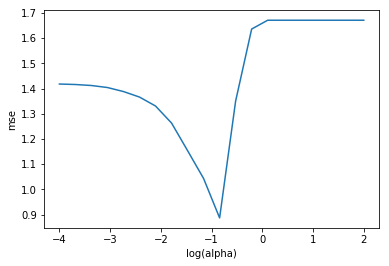

('alpha is:', 0.1438449888287663)


In [105]:
mses = np.mean(lasso.mse_path_, axis = 1)
plt.plot(np.log10(lasso.alphas_), mses) 
#这是为了标出最佳参数的位置
# plt.plot(np.log10(lasso.alphas_)*np.ones(3), [0.3, 0.4, 1.0])
plt.xlabel('log(alpha)')
plt.ylabel('mse')
plt.show()    
            
print ('alpha is:', lasso.alpha_)


上图，最优参数。        
小结：           
1）特征共线性对LASSO的影响：比起去掉体感温度，当温度和体感温度同时作为特征时，LASSO性能有提高；         
2）方法比较：课程讲，当数据集中特征维数很多且存在共线性时，LassoCV更合适，但是现在看LASSO没有ridge效果好，为什么？考虑可能是特征维数太小，且共线性程度不够，LASSO的降维作用，使能Lasso没有ridge效果好。

In [106]:
# 看看各特征的权重系数，系数的绝对值大小可视为该特征的重要性
fs = pd.DataFrame({"columns":list(columns), "coef_lr":list((lr.coef_.T)), "coef_ridge":list((ridge.coef_.T)), "coef_lasso":list((lasso.coef_.T))})
fs.sort_values(by=['coef_lr'],ascending=False)

,coef_lasso,coef_lr,coef_ridge,columns
6,0.545450,[0.6449039075072264],[0.6358317708538302],temp
0,0.194522,[0.29019802053253385],[0.2810389748075029],season
3,0.000000,[0.03566557031310492],[0.03459014329464005],weekday
1,0.000000,[0.009914171129053961],[0.019631518108113075],mnth
4,0.000000,[0.004316539173812384],[0.0046541107521047564],workingday
2,-0.000000,[-0.038639896354532],[-0.03847952747392469],holiday
7,-0.000000,[-0.09179701946161267],[-0.08965630261917445],hum
8,-0.003430,[-0.12223224558991738],[-0.12095302350234455],windspeed
5,-0.127073,[-0.1962887490407437],[-0.19540814602315792],weathersit


# 作业小结
1）根据数据特点，分析了自然环境对共享单车租车数量的影响，与常识一致；          
2）2012年的单车数量比2011年要增近一倍，从数据和分析上看不出来是什么因素，考虑是否有社会因素（思想文化、科技推动、环境观念对人的出行方式的影响）                        
3）特别分析了样本的特征处理和噪声点对预测结果的影响，影响很大；      
4）学习了回归问题的数据处理流程和常见的三类模型（lr+sgdr/ridge/lasso），获益良多；          
5）特别尝试了参数调优：多找几个点，调整查找范围，保持最小值在接近中心位置；         
6）库工具的使用只是一方面，了解工具背后的原理、算法、公式、优缺点才是更关键的学习内容        
7）总结的认识有待在后续课程中验证。

#=====end=====================